# BPPS Units Scheduling Optimization with Python & PyPSA library
(Jupyter notebook at http://www.pypsa.org)

In [1]:
import pypsa
import pandas as pd
import numpy as np
import gurobipy
import cplex
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
import scipy.stats as sp
import seaborn as sns
import time
import openpyxl

# Import the Generator parameters into the programe.

In [2]:
df_generator = pd.read_excel('df_generator_master_v1.xlsx', sheet_name="df_gen_200820", engine='openpyxl')
df_generator

,Unit,committable,p_min_pu,p_max_pu,marginal_cost,min_down_time,min_up_time,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,shut_down_cost,start_up_cost,efficiency,p_nom,p_nom_min,p_nom_max
0,C1,False,0.55,1,175,16,72,96,0,0.25,0.25,0.00,0.5,15000,18000,45.951536,330,180,330
1,C2,False,0.53,1,175,16,72,96,0,0.25,0.25,0.00,0.5,15000,18000,46.139289,340,180,340
2,C3,False,0.75,1,175,16,72,96,0,0.25,0.25,0.00,0.5,15000,18000,48.026721,320,260,320
3,C4,True,0.00,1,175,16,72,0,1,0.25,0.25,0.25,0.5,15000,18000,44.349498,305,50,305
4,C5,False,0.52,1,175,16,72,96,0,0.25,0.25,0.00,0.5,15000,18000,46.929155,345,180,345
5,C6,True,0.00,1,175,16,72,67,0,0.25,0.25,0.25,0.5,15000,18000,45.168316,335,50,335
6,C7,False,0.76,1,175,16,72,96,0,0.25,0.25,0.00,0.5,15000,18000,46.941128,315,260,315
7,C8,True,0.00,1,175,16,72,70,0,0.25,0.25,0.25,0.5,15000,18000,46.153174,340,50,340


# Import the Loading parameters into the programe.

In [3]:
df_load = pd.read_excel('df_generator_master_v1.xlsx', sheet_name="df_load_200820", engine='openpyxl')

df_load_2 = df_load.to_numpy()
elim = [0]
df_load_3 = np.delete(df_load_2, elim)

sets_of_snapshots = 1
p_set = df_load_3

nu = pypsa.Network()
nu.set_snapshots(range(len(p_set)*sets_of_snapshots))
nu.add("Bus","bus")

print("Load Profile of the date:")
print(p_set)

Load Profile of the date:
[1510 1420 1338 1252 1326 1260 1186 1116 1060 1060 1060 1060 1060 1203
 1178 1162 1145 1135 1120 1124 1151 1166 1201 1060 1060 1060 1112 1164
 1240 1290 1376 1452 1603 1647 1780 1870 2057 2076 2076 2154 2273 2171
 2206 2241 2265 2319 2353 2398 2420 2377 2376 2352 2362 2324 2295 2275
 2256 2230 2203 2217 2455 2599 2588 2585 2494 2464 2454 2447 2467 2442
 2456 2472 2476 2476 2494 2410 2587 2578 2630 2630 2264 2203 2329 2216
 2080 2004 1947 1823 2120 1997 1899 2025 1860 1780 1780 1628]


# Import generator parameters into the pypsa generator data frame.

In [4]:
#network.import_from_csv_folder(csv_folder_name) or #network.export_to_csv_folder(csv_folder_name)
#Adding and removing components one-by-one or #Network.add(class_name, name, **kwargs)
#It is assumed internally that the base power is 1 MVA.
#Note that if comittable is False and p_min_pu > 0, this represents a must-run condition.
#add a generator whose output does change over time

for i in range(0, 8, 1):
    unit_value = df_generator.loc[i].at['Unit']
    bus_name_value = "bus"
    committable_value = df_generator.loc[i].at['committable']
    p_min_pu_value = df_generator.loc[i].at['p_min_pu']
    p_max_pu_value = df_generator.loc[i].at['p_max_pu']
    marginal_cost_value = df_generator.loc[i].at['marginal_cost']
    min_down_time_value = df_generator.loc[i].at['min_down_time']
    min_up_time_value = df_generator.loc[i].at['min_up_time']
    up_time_before_value = df_generator.loc[i].at['up_time_before']
    down_time_before_value = df_generator.loc[i].at['down_time_before']
    ramp_limit_up_value = df_generator.loc[i].at['ramp_limit_up']
    ramp_limit_down_value = df_generator.loc[i].at['ramp_limit_down']
    ramp_limit_start_up_value = df_generator.loc[i].at['ramp_limit_start_up']
    ramp_limit_shut_down_value = df_generator.loc[i].at['ramp_limit_shut_down']
    shut_down_cost_value = df_generator.loc[i].at['shut_down_cost']
    start_up_cost_value = df_generator.loc[i].at['start_up_cost']
    efficiency_value = df_generator.loc[i].at['efficiency']
    p_nom_value = df_generator.loc[i].at['p_nom']
    p_nom_min_value = df_generator.loc[i].at['p_nom_min']
    p_nom_max_value = df_generator.loc[i].at['p_nom_max']
    
    nu.add("Generator",unit_value,bus = bus_name_value,
       committable=committable_value, 
       p_min_pu=p_min_pu_value,
       p_max_pu=p_max_pu_value,
       marginal_cost=marginal_cost_value,
       min_down_time=min_down_time_value,
       min_up_time=min_up_time_value,
       up_time_before=up_time_before_value,
       down_time_before=down_time_before_value,
       ramp_limit_up=ramp_limit_up_value,
       ramp_limit_down=ramp_limit_down_value,
       ramp_limit_start_up=ramp_limit_start_up_value,
       ramp_limit_shut_down=ramp_limit_shut_down_value,
       shut_down_cost=shut_down_cost_value,
       start_up_cost=start_up_cost_value,
       efficiency=efficiency_value,
       p_nom=p_nom_value,
       p_nom_min=p_nom_min_value,
       p_nom_max=p_nom_max_value )

#nu.generators.to_excel("output001.xlsx", sheet_name='generator') 
print(nu.generators)

attribute  bus control type  p_nom  p_nom_extendable  p_nom_min  p_nom_max  \
C1         bus      PQ       330.0             False      180.0      330.0   
C2         bus      PQ       340.0             False      180.0      340.0   
C3         bus      PQ       320.0             False      260.0      320.0   
C4         bus      PQ       305.0             False       50.0      305.0   
C5         bus      PQ       345.0             False      180.0      345.0   
C6         bus      PQ       335.0             False       50.0      335.0   
C7         bus      PQ       315.0             False      260.0      315.0   
C8         bus      PQ       340.0             False       50.0      340.0   

attribute  p_min_pu  p_max_pu  p_set  ...  shut_down_cost  min_up_time  \
C1             0.55       1.0    0.0  ...         15000.0           72   
C2             0.53       1.0    0.0  ...         15000.0           72   
C3             0.75       1.0    0.0  ...         15000.0           72   
C

# Start the simulation with "Gurobi" optimization.

In [5]:
nu.add("Load","load",bus="bus",p_set=p_set*sets_of_snapshots)

overlap = 8
for i in range(sets_of_snapshots):
    nu.lopf(nu.snapshots[i*len(p_set):(i+1)*len(p_set)+overlap], 
            pyomo=True, 
            solver_name="gurobi",            
            solver_options={}, 
            solver_logfile=None, 
            formulation="kirchhoff", 
            keep_files=True, 
            extra_functionality=None)


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `kirchhoff` formulation
INFO:pypsa.opf:Solving model using gurobi


Solver script file: 'C:\Users\yhmau\AppData\Local\Temp\tmp089gl7t8.gurobi.script'
Solver log file: 'C:\Users\yhmau\AppData\Local\Temp\tmp471yq1iy.gurobi.log'
Solver solution file: 'C:\Users\yhmau\AppData\Local\Temp\tmpqk20hep8.gurobi.txt'
Solver problem files: ('C:\\Users\\yhmau\\AppData\\Local\\Temp\\tmpyh3qp53m.pyomo.lp',)


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x1633
  Lower bound: 31770350.0
  Upper bound: 31770350.0
  Number of objectives: 1
  Number of constraints: 3339
  Number of variables: 1633
  Number of binary variables: 288
  Number of integer variables: 288
  Number of continuous variables: 1345
  Number of nonzeros: 24383
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was so

# Get the optimized cost value from the simulation: 

In [6]:
nu.objective
min_cost = nu.objective

print("* Absolute minimum cost of operation for coming 24hrs is HKD${}".format(min_cost))

* Absolute minimum cost of operation for coming 24hrs is HKD$31770350.0


# List out the status of all generators for each time slot in the simulation: 

In [7]:
## 24 hour format ##
time_now = time.strftime("(%H-%M-%S)")
## dd/mm/yyyy format
date_now = time.strftime("%Y_%m_%d")

status_output_file = "Generator_status_"+date_now+time_now+".xlsx"

nu.generators_t.status.to_excel(status_output_file, sheet_name='generator_status') 
nu.generators_t.status

,C1,C2,C3,C4,C5,C6,C7,C8
0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
3,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
4,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...,...
91,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
92,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
93,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
94,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


# Plot the ON/OFF status of all generators in the simulation: 

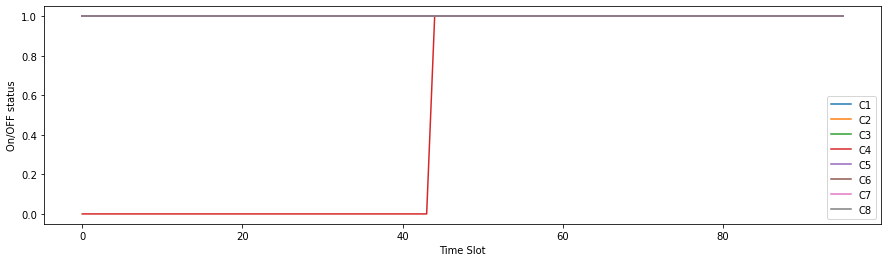

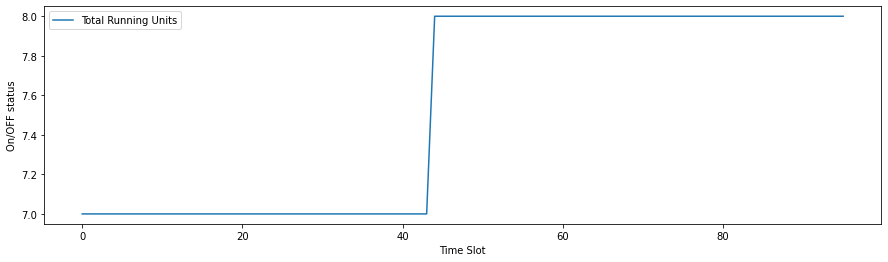

In [8]:
plt.figure(figsize=(15,4))
plt.plot(nu.generators_t.status)
plt.legend(["C1","C2","C3","C4","C5","C6","C7","C8"])
plt.xlabel('Time Slot')
plt.ylabel('On/OFF status')
plt.show()

plt.figure(figsize=(15,4))
plt.plot(nu.generators_t.status.sum(axis=1))
plt.legend(["Total Running Units"])
plt.xlabel('Time Slot')
plt.ylabel('On/OFF status')
plt.show()

# List out the loading profile of all generators in the simulation: 

In [9]:
## 24 hour format ##
time_now = time.strftime("(%H-%M-%S)")
## dd/mm/yyyy format
date_now = time.strftime("%Y_%m_%d")

loading_output_file = "Generator_loading_"+date_now+time_now+".xlsx"

nu.generators_t.p.to_excel(loading_output_file, sheet_name='generator_loading') 
nu.generators_t.p

,C1,C2,C3,C4,C5,C6,C7,C8
0,330.0,188.95,320.0,0.00,179.40,0.00,315.0,176.65
1,247.5,180.20,320.0,0.00,265.65,0.00,315.0,91.65
2,264.0,180.20,320.0,0.00,179.40,72.75,315.0,6.65
3,181.5,180.20,320.0,0.00,255.30,0.00,315.0,0.00
4,264.0,180.20,320.0,0.00,179.40,0.00,315.0,67.40
...,...,...,...,...,...,...,...,...
91,181.5,180.20,320.0,188.00,179.40,335.00,315.0,325.90
92,181.5,180.20,320.0,111.75,179.40,331.25,315.0,240.90
93,181.5,180.20,320.0,35.50,256.90,335.00,315.0,155.90
94,251.0,180.20,320.0,0.00,179.40,335.00,315.0,199.40


# Plot the loading profile of all generators in the simulation: 

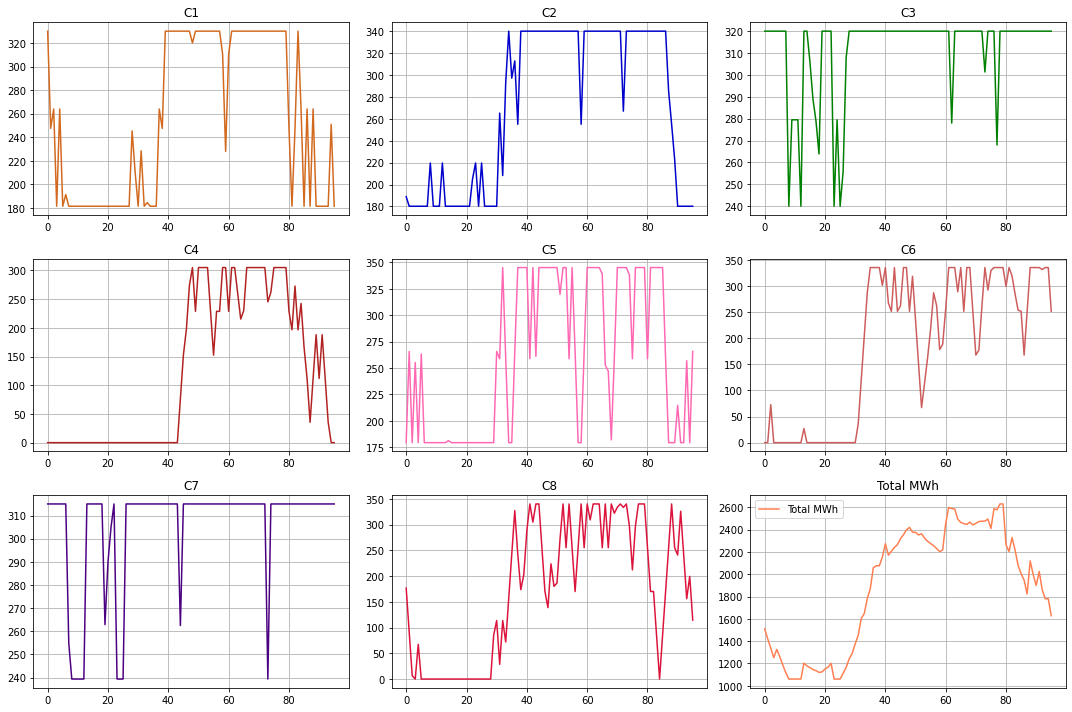

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(15,10))
axs[0, 0].plot(nu.generators_t.p.C1, color='#D2691E')
axs[0, 0].set_title("C1")
axs[0, 0].grid(True)
axs[0, 1].plot(nu.generators_t.p.C2, color='#0000CD')
axs[0, 1].set_title("C2")
axs[0, 1].grid(True)
axs[0, 2].plot(nu.generators_t.p.C3, color='#008000')
axs[0, 2].set_title("C3")
axs[0, 2].grid(True)
axs[1, 0].plot(nu.generators_t.p.C4, color='#B22222')
axs[1, 0].set_title("C4")
axs[1, 0].grid(True)
axs[1, 1].plot(nu.generators_t.p.C5, color='#FF69B4')
axs[1, 1].set_title("C5")
axs[1, 1].grid(True)
axs[1, 2].plot(nu.generators_t.p.C6, color='#CD5C5C')
axs[1, 2].set_title("C6")
axs[1, 2].grid(True)
axs[2, 0].plot(nu.generators_t.p.C7, color='#4B0082')
axs[2, 0].set_title("C7")
axs[2, 0].grid(True)
axs[2, 1].plot(nu.generators_t.p.C8, color='#DC143C')
axs[2, 1].set_title("C8")
axs[2, 1].grid(True)
axs[2, 2].plot(nu.generators_t.p.sum(axis=1), color='#FF7F50')
#axs[2, 2].legend(["C1","C2","C3","C4","C5","C6","C7","C8"])
axs[2, 2].set_title("Total MWh")
axs[2, 2].legend(["Total MWh"])
axs[2, 2].grid(True)
fig.tight_layout()
#plt.show()
# select plot colour https://www.cnblogs.com/darkknightzh/p/6117528.html

# List out the total MW generated in this simulation: 

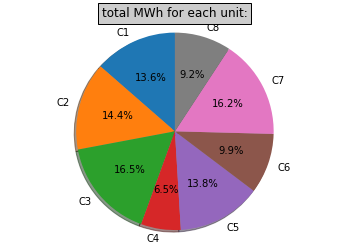

* Total MWh generated for coming 24hrs is 45360.5MWh


In [11]:
C1_total_MWh = nu.generators_t.p.C1.sum()/4
C2_total_MWh = nu.generators_t.p.C2.sum()/4
C3_total_MWh = nu.generators_t.p.C3.sum()/4
C4_total_MWh = nu.generators_t.p.C4.sum()/4
C5_total_MWh = nu.generators_t.p.C5.sum()/4
C6_total_MWh = nu.generators_t.p.C6.sum()/4
C7_total_MWh = nu.generators_t.p.C7.sum()/4
C8_total_MWh = nu.generators_t.p.C8.sum()/4

labels = 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'
sizes = [C1_total_MWh, 
         C2_total_MWh, 
         C3_total_MWh, 
         C4_total_MWh, 
         C5_total_MWh, 
         C6_total_MWh, 
         C7_total_MWh, 
         C8_total_MWh]
fig1, ax1 = plt.subplots()
plt.title('total MWh for each unit:', bbox={'facecolor':'0.8', 'pad':4})

ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Stn_total_MWh = round(C1_total_MWh+C2_total_MWh+C3_total_MWh+C4_total_MWh+C5_total_MWh+C6_total_MWh+C7_total_MWh+C8_total_MWh, 4)
print("* Total MWh generated for coming 24hrs is {}MWh".format(Stn_total_MWh))

# Calculate the gas used in "GJ" for each generator in the simulation:

In [12]:
#Heat Rate curve A, B, C parameters for each units
HRC_a = 0.000160962
HRC_b = 6.143642392
HRC_c = 396.9048624

df_gas_usage = nu.generators_t.p.copy()
#df_gas_usage_T_F = nu.generators_t.p.isin([0.0])

for i in range(0, 96, 1):
     for j in range(0, 8, 1):
        gas_temp_1 = (df_gas_usage.iloc[i:i+1,j:j+1]*df_gas_usage.iloc[i:i+1,j:j+1]*HRC_a+df_gas_usage.iloc[i:i+1,j:j+1]*HRC_b+HRC_c)/4 
        df_gas_usage[df_gas_usage.iloc[i:i+1,j:j+1] > 0] = gas_temp_1
                    
## 24 hour format ##
time_now = time.strftime("(%H-%M-%S)")
## dd/mm/yyyy format
date_now = time.strftime("%Y_%m_%d")

gas_output_file = "gas_consumption_"+date_now+time_now+".xlsx"
df_gas_usage.to_excel(gas_output_file, sheet_name='gas_consumption')
df_gas_usage

,C1,C2,C3,C4,C5,C6,C7,C8
0,610.458903,390.873194,594.838234,0.000000,376.063692,0.000000,587.030918,371.800536
1,481.829071,377.303996,594.838234,0.000000,510.080635,0.000000,587.030918,240.330431
2,507.511215,377.303996,594.838234,0.000000,376.063692,211.176687,587.030918,109.441801
3,379.319602,377.303996,594.838234,0.000000,493.966990,0.000000,587.030918,0.000000
4,507.511215,377.303996,594.838234,0.000000,376.063692,0.000000,587.030918,202.929393
...,...,...,...,...,...,...,...,...
91,379.319602,377.303996,594.838234,389.399668,376.063692,618.272256,587.030918,604.053456
92,379.319602,377.303996,594.838234,271.366751,376.063692,612.412053,587.030918,471.562348
93,379.319602,377.303996,594.838234,153.801755,496.457425,618.272256,587.030918,339.652716
94,487.274967,377.303996,594.838234,0.000000,376.063692,618.272256,587.030918,407.086766


# Calucate the total gas used in "GJ" in this simulation:

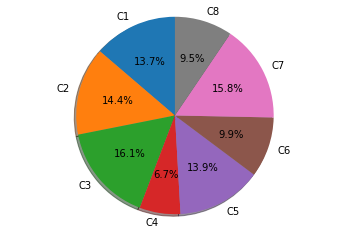

* Total gas used for coming 24hrs is 346983.6742GJ
* Total MWh generated for coming 24hrs is 45360.5MWh
* Absolute minimum cost of operation for coming 24hrs is HKD$31770350.0


In [13]:
C1_total_gas = df_gas_usage.C1.sum()
C2_total_gas = df_gas_usage.C2.sum()
C3_total_gas = df_gas_usage.C3.sum()
C4_total_gas = df_gas_usage.C4.sum()
C5_total_gas = df_gas_usage.C5.sum()
C6_total_gas = df_gas_usage.C6.sum()
C7_total_gas = df_gas_usage.C7.sum()
C8_total_gas = df_gas_usage.C8.sum()
Stn_total_gas = round(C1_total_gas+C2_total_gas+C3_total_gas+C4_total_gas+C5_total_gas+C6_total_gas+C7_total_gas+C8_total_gas, 4)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8'
sizes = [C1_total_gas, C2_total_gas, C3_total_gas, C4_total_gas, C5_total_gas, C6_total_gas, C7_total_gas, C8_total_gas]
fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

print("* Total gas used for coming 24hrs is {}GJ".format(Stn_total_gas))
print("* Total MWh generated for coming 24hrs is {}MWh".format(Stn_total_MWh))
print("* Absolute minimum cost of operation for coming 24hrs is HKD${}".format(min_cost))

# END of programme!!